<a href="https://colab.research.google.com/github/nanom/textMining2021/blob/main/final_project/clustering_first_approach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1) Environment config

#### 1.1 Check GPU device capabilities

In [ ]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



#### 1.2 Installations of libs (Assure set enviroment to work on GPU)

In [ ]:
# Install libs
!pip install -U pip setuptools wheel --quiet
!pip install -U spacy[cuda101] --quiet
!python -m spacy download en_core_web_md --quiet
!pip install contractions --quiet

#### 1.3 Import libs

In [ ]:
# --- Import libs ---
import spacy
import contractions as ctr

import pandas as pd
# import cupy
import random
import numpy as np
from tqdm import tqdm
from collections import Counter

# Plotting libs
import seaborn as snb
import matplotlib.pyplot as plt
from yellowbrick.cluster import SilhouetteVisualizer
import plotly.graph_objs as go

# Sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn import preprocessing, feature_selection, metrics

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


#### 1.4 Drive access and gral config

In [ ]:
# --- Acceso a drive ---
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

# --- Files Path ----
PATH = "/content/gdrive/MyDrive/cursos/textMining2021/proy_final/"
SOURCE_FOLDER = PATH + "source/"
OUT_DFS_FOLDER = PATH + "out_dataframes/"


# --- Visual pandas proggress ---
tqdm.pandas()

 # --- Enable spacy gpu ---
try:
    print("SpaCy GPU available? {}".format(spacy.require_gpu()))
    # print("SpaCy GPU available? {}".format(spacy.prefer_gpu()))
except:
    print("GPU not available. Spacy will work with CPU.")

Mounted at /content/gdrive
GPU not available. Spacy will work with CPU.


# 2) Generate corpus of questions and answers
---



In [ ]:
# Load test, val and train VizWiz-VQA datasets
train = pd.read_json(SOURCE_FOLDER+"train.json")
val = pd.read_json(SOURCE_FOLDER+"val.json")
test = pd.read_json(SOURCE_FOLDER+"test.json")

In [ ]:
# Generate corpus of questions and answers_list (Use validation and training sets because val set no containt answerss) 
raw_corpus = pd.concat([train[['question','answers']], val[['question','answers']]])

## Convert list of dic answers to list of unique answers 
raw_corpus['answers'] = raw_corpus.answers.progress_apply(lambda x: [v for dic in x for k,v in dic.items() if k == 'answer'])

### Sort answers list by agreement 
raw_corpus['answers'] = raw_corpus.answers.progress_apply(lambda x: Counter(x).most_common())

## Expand contractions of questions
raw_corpus['question'] = raw_corpus.question.progress_apply(lambda qs: ctr.fix(qs).lower())

## Delete questions duplicate
raw_corpus = raw_corpus.drop_duplicates(subset="question")

## Add number of sentence that contain each question
pln = spacy.load('en_core_web_md')
raw_corpus = raw_corpus.assign(num_sents=raw_corpus.question.progress_apply(lambda qs: len(list(pln(qs).sents))))

## Filter question with more that one sentence
_total = len(raw_corpus)
raw_corpus = raw_corpus[raw_corpus.num_sents == 1]
_one_sent = len(raw_corpus)
print("\nNumber of questions with only one sent: {}/{} ({:.2f}%)".format(_one_sent, _total, _one_sent*100/_total))


# Save dataframe
raw_corpus = raw_corpus[['question', 'answers']]
raw_corpus.reset_index(inplace=True, drop=True)
raw_corpus.to_pickle(OUT_DFS_FOLDER+"raw_corpus.pkl")

#  Test
print("{} questions retrieved!".format(len(raw_corpus)))
raw_corpus

100%|██████████| 12151/12151 [01:30<00:00, 133.91it/s]

Number of questions with only one sent: 9215/12151 (75.84%)
9215 questions retrieved!


,question,answers
0,what is the name of this product?,"[(basil leaves, 7), (basil, 3)]"
1,can you tell me what is in this can please?,"[(coca cola, 3), (unsuitable, 2), (coke 0, 2),..."
2,what is the captcha on this screenshot?,"[(t36m, 8), (t 3 6 m, 1), (t63m, 1)]"
3,what is this item?,"[(solar garden light, 8), (solar light, 1), (g..."
4,what is this?,"[(shoes, 4), (boots, 2), (feet, 2), (unanswera..."
...,...,...
9210,and how big is it?,"[(unanswerable, 4), (about 32 inches, 1), (32 ..."
9211,how many tablets are in this box?,"[(8, 8), (8 tablets, 2)]"
9212,what is this in front of the camera?,"[(computer, 3), (laptop, 1), (computer monitor..."
9213,is this modern?,"[(unsuitable, 7), (no, 1), (unanswerable, 1), ..."


#### 2.1) Add column with question's lemmas, PoS and tokens. Add columns with answers lemmatization and tokens

In [ ]:
# Load spacy model to generate token and PoS by each questions and answers
pln = spacy.load('en_core_web_md')

def question2PosAndTokens(question):
    # Only get alphabetic tokens
    doc = pln(question)
    tks_list, lemma_list, pos_list = ['CLS'], ['CLS'], ['CLS']
    for tk in doc:
        if tk.is_alpha:
            pos_list.append(tk.pos_)
            lemma_list.append(tk.lemma_.lower())
            tks_list.append(tk.text.lower())
    tks_list.append('SEP')
    lemma_list.append('SEP')
    pos_list.append('SEP')
    return tks_list, lemma_list, pos_list

def ans2Tokens(ans_list):
    tks_list, lemma_list = [], []
    for ans in ans_list:
        temp_tokens = [tk.text.lower() for tk in pln(ans[0])]
        temp_lemmas = [tk.lemma_.lower() for tk in pln(ans[0])]
        
        tks_list.append(temp_tokens+['SEP'])
        lemma_list.append(temp_lemmas+['SEP'])
    return tks_list, lemma_list

# Test functions
q1 = "Can you tell me what is in this can please?"
ans1 = [('basil leaves', 7), ('basil', 2), ('t63m', 1)]
r = question2PosAndTokens(q1)
a = ans2Tokens(ans1)

print("Q1: {}".format(q1))
print("\t tokens -> {}".format(r[0]))
print("\t lemmas -> {}".format(r[1]))
print("\t pos -> {}".format(r[2]))
print("Ans: {}".format(ans1))
print("\t tokens -> {}".format(a[0]))
print("\t lemmas -> {}".format(a[1]))

Q1: Can you tell me what is in this can please?
	 tokens -> ['CLS', 'can', 'you', 'tell', 'me', 'what', 'is', 'in', 'this', 'can', 'please', 'SEP']
	 lemmas -> ['CLS', 'can', 'you', 'tell', 'i', 'what', 'be', 'in', 'this', 'can', 'please', 'SEP']
	 pos -> ['CLS', 'AUX', 'PRON', 'VERB', 'PRON', 'PRON', 'VERB', 'ADP', 'DET', 'AUX', 'VERB', 'SEP']
Ans: [('basil leaves', 7), ('basil', 2), ('t63m', 1)]
	 tokens -> [['basil', 'leaves', 'SEP'], ['basil', 'SEP'], ['t63', 'm', 'SEP']]
	 lemmas -> [['basil', 'leave', 'SEP'], ['basil', 'SEP'], ['t63', 'm', 'SEP']]


In [ ]:
# # Load corpus
raw_corpus = pd.read_pickle(OUT_DFS_FOLDER+"raw_corpus.pkl")

# Add column with tokens lemmas and PoS for each question
raw_corpus = raw_corpus.assign(temp=raw_corpus.question.progress_apply(lambda qs: question2PosAndTokens(qs)))
raw_corpus = raw_corpus.assign(qs_tks=raw_corpus.temp.progress_apply(lambda x: x[0]))
raw_corpus = raw_corpus.assign(qs_lemmas=raw_corpus.temp.progress_apply(lambda x: x[1]))
raw_corpus = raw_corpus.assign(qs_pos=raw_corpus.temp.progress_apply(lambda x: x[2]))
raw_corpus.drop(columns={'temp'}, inplace=True)

# Add column with tokens list for each answer
raw_corpus = raw_corpus.assign(temp=raw_corpus.answers.progress_apply(lambda ans: ans2Tokens(ans)))
raw_corpus = raw_corpus.assign(ans_tks=raw_corpus.temp.progress_apply(lambda x: x[0]))
raw_corpus = raw_corpus.assign(ans_lemmas=raw_corpus.temp.progress_apply(lambda x: x[1]))
raw_corpus.drop(columns={'temp'}, inplace=True)

# Save new corpus
raw_corpus.to_pickle(OUT_DFS_FOLDER+'proc_corpus.pkl')
raw_corpus

100%|██████████| 9215/9215 [00:00<00:00, 559519.84it/s]


,question,answers,qs_tks,qs_lemmas,qs_pos,ans_tks,ans_lemmas
0,what is the name of this product?,"[(basil leaves, 7), (basil, 3)]","[CLS, what, is, the, name, of, this, product, ...","[CLS, what, be, the, name, of, this, product, ...","[CLS, PRON, AUX, DET, NOUN, ADP, DET, NOUN, SEP]","[[basil, leaves, SEP], [basil, SEP]]","[[basil, leave, SEP], [basil, SEP]]"
1,can you tell me what is in this can please?,"[(coca cola, 3), (unsuitable, 2), (coke 0, 2),...","[CLS, can, you, tell, me, what, is, in, this, ...","[CLS, can, you, tell, i, what, be, in, this, c...","[CLS, AUX, PRON, VERB, PRON, PRON, VERB, ADP, ...","[[coca, cola, SEP], [unsuitable, SEP], [coke, ...","[[coca, cola, SEP], [unsuitable, SEP], [coke, ..."
2,what is the captcha on this screenshot?,"[(t36m, 8), (t 3 6 m, 1), (t63m, 1)]","[CLS, what, is, the, captcha, on, this, screen...","[CLS, what, be, the, captcha, on, this, screen...","[CLS, PRON, AUX, DET, NOUN, ADP, DET, NOUN, SEP]","[[t36, m, SEP], [t, 3, 6, m, SEP], [t63, m, SEP]]","[[t36, m, SEP], [t, 3, 6, m, SEP], [t63, m, SEP]]"
3,what is this item?,"[(solar garden light, 8), (solar light, 1), (g...","[CLS, what, is, this, item, SEP]","[CLS, what, be, this, item, SEP]","[CLS, PRON, AUX, DET, NOUN, SEP]","[[solar, garden, light, SEP], [solar, light, S...","[[solar, garden, light, SEP], [solar, light, S..."
4,what is this?,"[(shoes, 4), (boots, 2), (feet, 2), (unanswera...","[CLS, what, is, this, SEP]","[CLS, what, be, this, SEP]","[CLS, PRON, AUX, DET, SEP]","[[shoes, SEP], [boots, SEP], [feet, SEP], [una...","[[shoe, SEP], [boot, SEP], [foot, SEP], [unans..."
...,...,...,...,...,...,...,...
9210,and how big is it?,"[(unanswerable, 4), (about 32 inches, 1), (32 ...","[CLS, and, how, big, is, it, SEP]","[CLS, and, how, big, be, it, SEP]","[CLS, CCONJ, ADV, ADJ, AUX, PRON, SEP]","[[unanswerable, SEP], [about, 32, inches, SEP]...","[[unanswerable, SEP], [about, 32, inch, SEP], ..."
9211,how many tablets are in this box?,"[(8, 8), (8 tablets, 2)]","[CLS, how, many, tablets, are, in, this, box, ...","[CLS, how, many, tablet, be, in, this, box, SEP]","[CLS, ADV, ADJ, NOUN, AUX, ADP, DET, NOUN, SEP]","[[8, SEP], [8, tablets, SEP]]","[[8, SEP], [8, tablet, SEP]]"
9212,what is this in front of the camera?,"[(computer, 3), (laptop, 1), (computer monitor...","[CLS, what, is, this, in, front, of, the, came...","[CLS, what, be, this, in, front, of, the, came...","[CLS, PRON, AUX, DET, ADP, NOUN, ADP, DET, NOU...","[[computer, SEP], [laptop, SEP], [computer, mo...","[[computer, SEP], [laptop, SEP], [computer, mo..."
9213,is this modern?,"[(unsuitable, 7), (no, 1), (unanswerable, 1), ...","[CLS, is, this, modern, SEP]","[CLS, be, this, modern, SEP]","[CLS, AUX, DET, ADJ, SEP]","[[unsuitable, SEP], [no, SEP], [unanswerable, ...","[[unsuitable, SEP], [no, SEP], [unanswerable, ..."


# 4) Clustering

#### 4.1 Load Corpus - Auxiliar functions

In [ ]:
# Load corpus
corpus = pd.read_pickle(OUT_DFS_FOLDER+"proc_corpus.pkl")

# Functions
def normAndReduction(features, _threshold_var=.001, _reduction=True):

    # Normalization by examples due the distribution of frequency words is exponential
    features = preprocessing.normalize(features, axis=1, norm='l2')
    print("Features dimensionality post Normalization: {}".format(features.shape))

    if _reduction:
        # Decrease in dimensionality by variance threshold. That is: I remove features (columns) 
        # with very low variability (less than '_threshold_var').
        selector = feature_selection.VarianceThreshold(_threshold_var)
        features = selector.fit_transform(features)

        print("Post (Norm + Dimensionality reduction): {}".format(features.shape))

    return pd.DataFrame(features)

def myKmeans(features, k, max_iter=300, n_init=10):
    """
    Search clusters using Kmenas method
    """

    km_model = KMeans(  n_clusters=k,
                        max_iter=max_iter, 
                        n_init=n_init, 
                        verbose=False)
    km_model.fit(features)
    
    print(Counter(km_model.labels_))
    return km_model

def silhouettePlot(km_model):
    # Config fig
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))

    # --- Plot Silhouette ---
    visualizer = SilhouetteVisualizer(km_model,  colors='yellowbrick', ax=ax)
    
    # Fit the data to the visualizer
    visualizer.fit(features)


def getQuestionByClusters(data, _qs_numbers):
    limit_to_print = 100
    for l in sorted(data.labels.unique()):
        print("\n[Cluster {}] --- {} shuffle questions\n------".format(l, _qs_numbers))
        questions = data[data.labels == l]
        questions_list = questions.head(_qs_numbers).question.to_list()
        random.shuffle(questions_list)
        for j,qs in enumerate(questions_list):
            ppp = "..." if len(qs) > limit_to_print else ""
            print("{}) {}{}".format(j,qs[:limit_to_print], ppp), sep="\n ")
        print("")


#### 4.2 <i>Exploration using **Lemmas**</i>

<u>Vectorization:</u>

In [ ]:
def my_preprocessor(text):
    # Here filter o select determinates tokens
    return text

def my_tokenizer(text):
    # Nothing. The input is alredy a list of tokens
    return text

# Get features matrix from questions lemmas list
cv = CountVectorizer(   tokenizer=my_tokenizer, 
                        preprocessor=my_preprocessor, 
                        ngram_range=(1,1), min_df=2)
features = cv.fit_transform(corpus.qs_lemmas.to_list()).toarray()

# Normalization y reduction
features = normAndReduction(features, _threshold_var=.001, _reduction=True)

Features dimensionality post Normalization: (9215, 2747)
Post (Norm + Dimensionality reduction): (9215, 73)


<u>Kmeans aplication and plot Silhouette plot:</u>

Counter({21: 897, 12: 501, 2: 499, 9: 488, 3: 412, 7: 396, 28: 367, 8: 352, 1: 330, 18: 329, 24: 293, 6: 286, 19: 285, 11: 284, 22: 282, 5: 275, 10: 273, 16: 266, 29: 261, 15: 258, 26: 241, 23: 233, 4: 229, 25: 226, 20: 187, 27: 177, 17: 168, 13: 148, 14: 147, 0: 125})


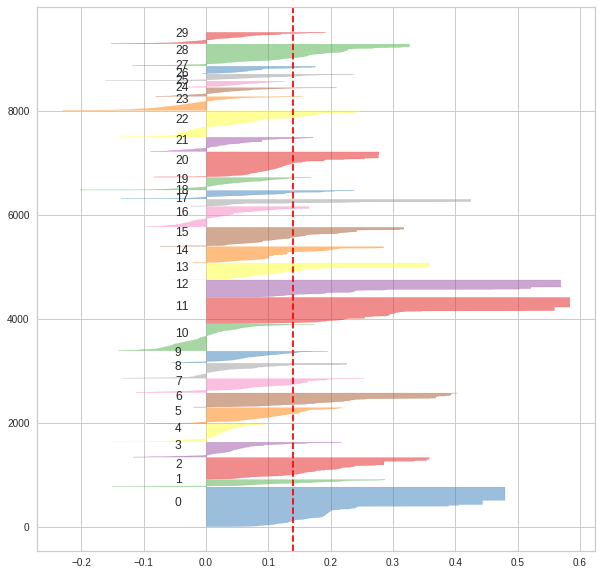

In [ ]:
# Run Kmeans model and generate Silhouette PLot to supervise the progress and select the optimal k value
NUM_CLUSTERS = 30
model = myKmeans(features, NUM_CLUSTERS, max_iter=300, n_init=10)
silhouettePlot(model)

<u>Results:</u> 

In [ ]:
# Generate dataframe with questions and labels
data = corpus[['question']].assign(labels=model.labels_)

# Print questions for each clusters
getQuestionByClusters(data, 20)


[Cluster 0] --- 20 shuffle questions
------
0) what is this movie?
1) what is this photo?
2) what is this cd?
3) what this student planner?
4) what seasoning is this?
5) what is this coin? 
6) what book is this?
7) what is this
8) what is this island?
9) what is this? 
10) what is this item?
11) what can is this?
12) what is this game?
13) what canned good is this? 
14) what is this bottle?
15) what golf course logo is this from?
16) what is this item.
17) what soap is this?
18) what is this spice?
19) what is this?


[Cluster 1] --- 20 shuffle questions
------
0) this guy look like.
1) what does he look like?
2) guy look like in this picture.
3) did it...does it look like it is going to storm?
4) the sky look like?
5) do the clouds look like they are building up for a big storm?
6) what color do these look?
7) does the clouds look like storm clouds or rain clouds?
8) does this look like sheet music?
9) the chair looked like
10) what do i look like?
11) what does this look like and wh

#### 4.3 Exploration using **Lemmas** most frequents (**tf** and **min_df**)

###### Filter by Term Frequence (*tf*)

1224/2747 (44.56%) lemmas with freq <= 1
1627/2747 (59.23%) lemmas with freq <= 2
1824/2747 (66.40%) lemmas with freq <= 3
1967/2747 (71.61%) lemmas with freq <= 4
2046/2747 (74.48%) lemmas with freq <= 5
2120/2747 (77.18%) lemmas with freq <= 6
2175/2747 (79.18%) lemmas with freq <= 7
2223/2747 (80.92%) lemmas with freq <= 8
2258/2747 (82.20%) lemmas with freq <= 9
2295/2747 (83.55%) lemmas with freq <= 10


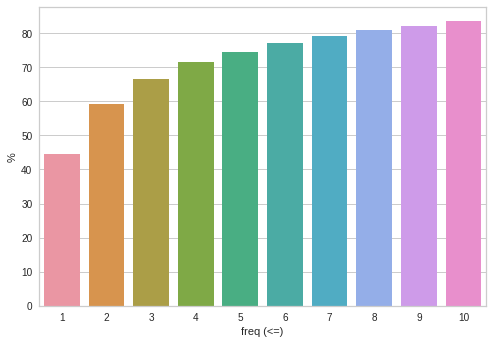

In [ ]:
# Questions Lemmas frequence
qs_lemmas_dic = Counter([l for l_list in corpus.qs_lemmas.to_list() for l in l_list])
qs_lemmas_df = pd.DataFrame(qs_lemmas_dic.most_common())
qs_lemmas_df.reset_index(drop=True, inplace=True)
qs_lemmas_df.rename(columns={0:'lemma', 1:'freq'}, inplace=True)

# Frecuence percentage
perc_list = []
freq_list = list(range(1,11))
_total = len(qs_lemmas_df)
for freq in freq_list:
    _partial = len(qs_lemmas_df[qs_lemmas_df.freq <= freq])
    perc_list.append(_partial*100/_total)
    print("{}/{} ({:.2f}%) lemmas with freq <= {}".format(_partial, _total, _partial*100/_total, freq))

g = snb.barplot(x=freq_list, y=perc_list)
g.set_xlabel("freq (<=)")
g.set_ylabel("%")
plt.show()

<u>Vectorization:</u>

In [ ]:
def my_preprocessor(text):
    # Here filter o select determinates tokens
    getFreqByLemma = lambda x: qs_lemmas_dic[x]
    lemma_clean = [l for l in text if getFreqByLemma(l) > 1]
    return lemma_clean

def my_tokenizer(text):
    # Nothing. The input is alredy a list of tokens
    return text

# Get features matrix from questions lemmas list
cv = CountVectorizer(   tokenizer=my_tokenizer, 
                        preprocessor=my_preprocessor, 
                        ngram_range=(1,1))
features = cv.fit_transform(corpus.qs_lemmas.to_list()).toarray()

# Normalization y reduction
features = normAndReduction(features, _threshold_var=.001, _reduction=True)

Features dimensionality post Normalization: (9215, 1523)
Post (Norm + Dimensionality reduction): (9215, 74)


<u>Kmeans aplication and plot Silhouette plot:</u>

Counter({19: 861, 6: 509, 15: 497, 1: 417, 9: 413, 11: 389, 25: 377, 10: 360, 8: 360, 21: 358, 3: 338, 2: 332, 26: 330, 24: 321, 7: 300, 17: 293, 5: 293, 14: 286, 28: 250, 4: 237, 18: 228, 16: 206, 27: 205, 22: 198, 20: 180, 0: 173, 23: 169, 13: 148, 29: 146, 12: 41})


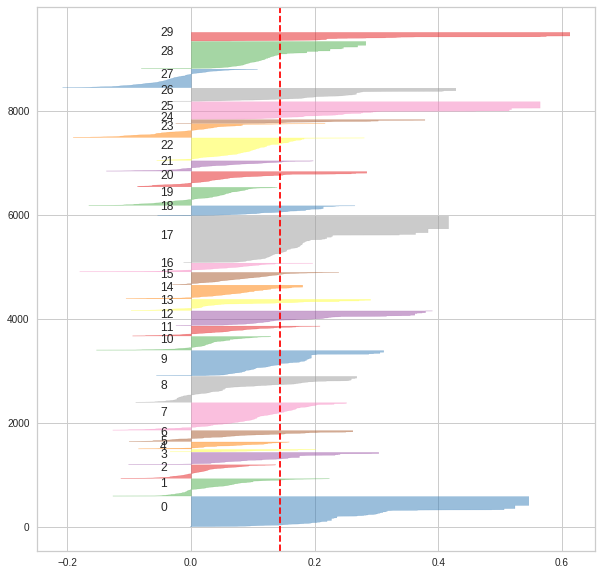

In [ ]:
# Run Kmeans model and generate Silhouette PLot to supervise the progress and select the optimal k value
NUM_CLUSTERS = 30
model = myKmeans(features, NUM_CLUSTERS, max_iter=300, n_init=10)
silhouettePlot(model)

<u>Results:</u> 

In [ ]:
# Generate dataframe with questions and labels
data = corpus[['question']].assign(labels=model.labels_)

# Print questions for each clusters
getQuestionByClusters(data, 20)


[Cluster 0] --- 20 shuffle questions
------
0) hi, what kind of can is this? 
1) what kind of granola bar is this?
2) what kind of candy bar is this?
3) what kind of coffee is this?
4) what kind of computer is this?
5) what kind of popsicle is this?
6) what kind of box is this?
7) what kind of soda is this
8) what kind of bar is this?
9) what kind of chips are these?
10) what kind of jerky is this? 
11) what kind of tea is this?
12) what kind of alcohol is this?
13) what kind of bottle of liquor is this? 
14) what kind of drink is this?
15) what kind of currency is this?
16) please tell me what kind of car this is
17) what kind of soda is that please?
18) what kind of drink is it?
19) what kind of snacks are these?


[Cluster 1] --- 20 shuffle questions
------
0) what is the color of the fat?
1) what is the name of the cd?
2) i do not know if this is the front or the back of the package.
3) where on the screen is the uninstall button?
4) what is on this tea ring and the name of the bo

##### Filter by min document frequence (*min_df*)

<u>Vectorization:</u>

In [ ]:
def my_preprocessor(text):
    # Here filter o select determinates tokens
    return text

def my_tokenizer(text):
    # Nothing. The input is alredy a list of tokens
    return text

# Get features matrix from questions lemmas list
cv = CountVectorizer(   tokenizer=my_tokenizer, 
                        preprocessor=my_preprocessor, 
                        ngram_range=(1,1), min_df=10)
features = cv.fit_transform(corpus.qs_lemmas.to_list()).toarray()

# Normalization y reduction
features = normAndReduction(features, _threshold_var=.001, _reduction=True)

Features dimensionality post Normalization: (9215, 482)
Post (Norm + Dimensionality reduction): (9215, 77)


<u>Kmeans aplication and plot Silhouette plot:</u>

Counter({4: 933, 14: 555, 2: 507, 27: 487, 26: 485, 16: 404, 12: 375, 1: 368, 8: 344, 23: 336, 24: 322, 9: 284, 19: 266, 21: 251, 11: 250, 18: 242, 13: 239, 6: 238, 15: 233, 29: 230, 10: 224, 3: 219, 7: 206, 0: 205, 28: 198, 22: 193, 25: 176, 17: 162, 20: 148, 5: 135})


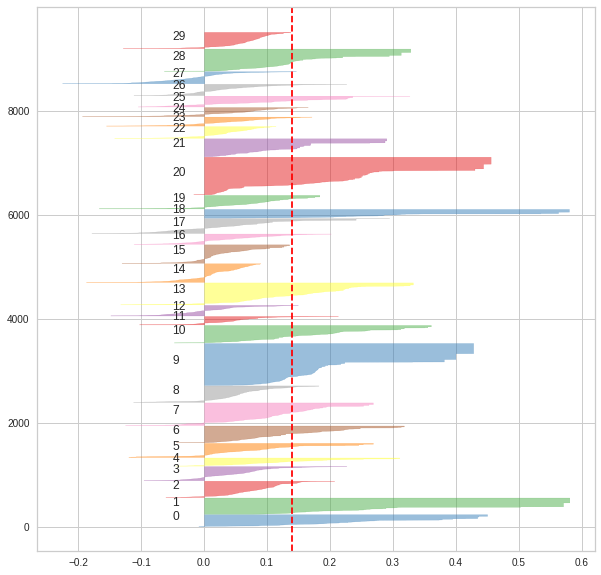

In [ ]:
# Run Kmeans model and generate Silhouette PLot to supervise the progress and select the optimal k value
NUM_CLUSTERS = 30
model = myKmeans(features, NUM_CLUSTERS, max_iter=300, n_init=10)
silhouettePlot(model)

<u>Results:</u> 

In [ ]:
# Generate dataframe with questions and labels
data = corpus[['question']].assign(labels=model.labels_)

# Print questions for each clusters
getQuestionByClusters(data, 20)


[Cluster 0] --- 20 shuffle questions
------
0) is this dayquil or nightquil?
1) are these plain or chili cheese fritos?
2) is this like on or off?
3) is this shampoo or conditioner?
4) are these low cut or crew ?
5) is this butter salted or unsalted?
6) is this card upside down or right side up?
7) is this upside down or right side up?
8) is this shampoo or conditioner
9) is this air conditioner on fan, dehumidify or air conditioning?
10) is this black or purple?
11) is this shampoo or soap?
12) are these the apple cinnamon or strawberry cereal bars?
13) is this lotion, shampoo, or conditioner?
14) hi is the can of soft drink in my right hand pepsi or coke or root beer?
15) is this regular or decaffeinated coffee?
16) is this regular or decaf coffee?
17) is this on air, fan or dehumidifier?
18) is this kraft catalina class or kraft catalina fat free?
19) is this pudding or applesauce?


[Cluster 1] --- 20 shuffle questions
------
0) what color is this hair band?
1) what color is this 

#### 4.4 Exploration using **Lemmas** (1-gram, 2-gram, and 3-gram)

<u>Vectorization:</u>

In [ ]:
def my_preprocessor(text):
    # Here filter o select determinates tokens
    return text

def my_tokenizer(text):
    # Nothing. The input is alredy a list of tokens
    return text

# Get features matrix from questions lemmas list
cv = CountVectorizer(   tokenizer=my_tokenizer, 
                        preprocessor=my_preprocessor, 
                        ngram_range=(1,3), min_df=2)
features = cv.fit_transform(corpus.qs_lemmas.to_list()).toarray()

# Normalization y reduction
features = normAndReduction(features, _threshold_var=.001, _reduction=True)

Features dimensionality post Normalization: (9215, 43571)
Post (Norm + Dimensionality reduction): (9215, 87)


<u>Kmeans aplication and plot Silhouette plot:</u>

Counter({7: 565, 19: 504, 5: 483, 10: 461, 21: 444, 23: 408, 25: 393, 8: 373, 22: 369, 15: 348, 1: 344, 28: 333, 17: 327, 27: 327, 12: 295, 0: 281, 26: 277, 20: 267, 14: 258, 16: 258, 3: 256, 6: 240, 4: 240, 29: 229, 18: 207, 11: 195, 2: 161, 13: 158, 24: 152, 9: 62})


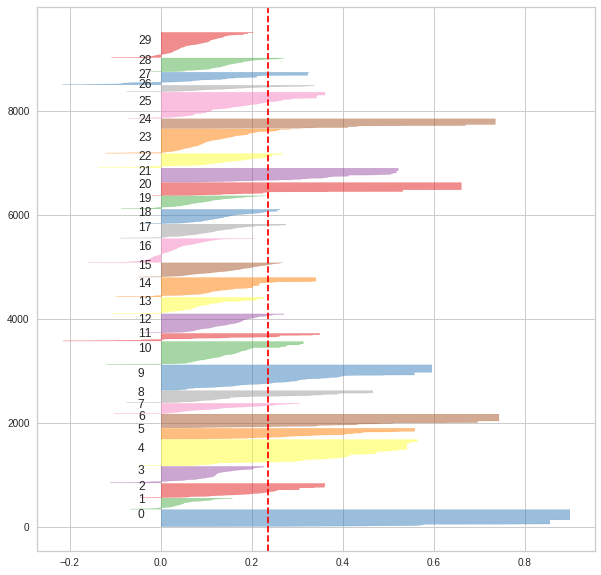

In [ ]:
# Run Kmeans model and generate Silhouette PLot to supervise the progress and select the optimal k value
NUM_CLUSTERS = 30
model = myKmeans(features, NUM_CLUSTERS, max_iter=300, n_init=10)
silhouettePlot(model)

<u>Results:</u> 

In [ ]:
# Generate dataframe with questions and labels
data = corpus[['question']].assign(labels=model.labels_)

# Print questions for each clusters
getQuestionByClusters(data, 20)


[Cluster 0] --- 20 shuffle questions
------
0) what kind of granola bar is this?
1) what kind of bottle of liquor is this? 
2) what kind of jerky is this? 
3) what kind of computer is this?
4) what kind of currency is this?
5) what kind of coffee is this?
6) what kind of soda is this?
7) what kind of bar is this?
8) what kind of drink is this?
9) what kind of can is this? 
10) what kind of box is this?
11) what kind of tea is this?
12) what kind of pattern and the color the shirt is this?
13) hi, what kind of can is this? 
14) what kind of popsicle is this?
15) what kind of soda is this
16) what kind of wine is this?
17) what kind of alcohol is this?
18) what kind of candy bar is this?
19) what kind of cologne is this?


[Cluster 1] --- 20 shuffle questions
------
0) i need to know the brand name on these headphones please.
1) please identify this cd.
2) please identify this picture?
3) read everything on that please.
4) please tell me the readings on this thermostat.
5) please descri

#### 4.5 Exploration using 3-gram of **PoS**

<u>Vectorization:</u>

In [ ]:
def my_preprocessor(text):
    # Here filter o select determinates tokens
    return text

def my_tokenizer(text):
    # Nothing. The input is alredy a list of tokens
    return text

# Get features matrix from questions lemmas list
cv = CountVectorizer(   tokenizer=my_tokenizer, 
                        preprocessor=my_preprocessor, 
                        ngram_range=(3,3), min_df=2)
features = cv.fit_transform(corpus.qs_pos.to_list()).toarray()

# Normalization y reduction
features = normAndReduction(features, _threshold_var=.001, _reduction=True)

Features dimensionality post Normalization: (9215, 1099)
Post (Norm + Dimensionality reduction): (9215, 130)


<u>Kmeans aplication and plot Silhouette plot:</u>

Counter({28: 925, 3: 629, 4: 582, 12: 500, 19: 480, 13: 475, 14: 393, 21: 390, 11: 357, 29: 353, 8: 311, 9: 289, 7: 284, 23: 271, 10: 267, 1: 232, 20: 223, 24: 215, 15: 206, 0: 203, 25: 199, 6: 192, 16: 185, 18: 184, 2: 167, 27: 164, 22: 150, 26: 139, 5: 138, 17: 112})


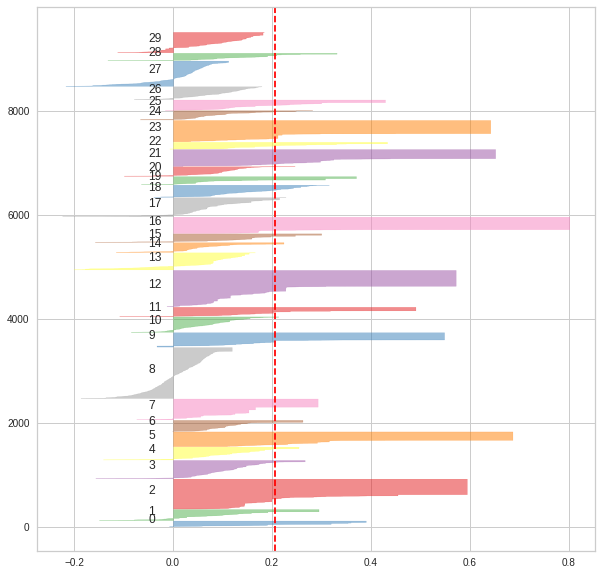

In [ ]:
# Run Kmeans model and generate Silhouette PLot to supervise the progress and select the optimal k value
NUM_CLUSTERS = 30
model = myKmeans(features, NUM_CLUSTERS, max_iter=300, n_init=10)
silhouettePlot(model)

<u>Results:</u> 

In [ ]:
# Generate dataframe with questions and labels
data = corpus[['question']].assign(labels=model.labels_)

# Print questions for each clusters
getQuestionByClusters(data, 20)


[Cluster 0] --- 20 shuffle questions
------
0) any writing on this?
1) what kind of logging tool is this?
2) what kind of jimmy deans breakfast sandwiches are these?
3) what kind of hot pockets are these?
4) what kind of pattern and the color the shirt is this?
5) what kind of a can is this?
6) what kind of keurig cup is this?
7) what kind of multipurpose sprayer is this?
8) what kind of k-cup is this? 
9) what kind of hot pockets are these? 
10) what kind of hot pocket?
11) what type of canned good is this?
12) what kind of goldfish crackers are these?
13) what kind of soft drink is this can?
14) what kind of a meal is this?
15) what kind of soup it this?
16) what type of mccains meal is this?
17) what kind of k-cup is this?
18) what kind of sam adam's is this?
19) what kind of cleaner is this?


[Cluster 1] --- 20 shuffle questions
------
0) what is the contents of this can please?
1) what is this picture of?
2) what is this a can of?
3) what are the instructions for this?
4) i woul

#### 4.6 Exploration using concatenation of **Question** and **Best answer agreement** lemmas.

<u>Vectorization:</u>

In [ ]:
# Merge qs and answers [CLS, qs, SEP, ans1, SEP, ans2, SEP, ansn, SEP]
qs_ans_list = list(zip(corpus.qs_lemmas.to_list(), corpus.ans_lemmas.to_list()))
print(*qs_ans_list[:10], sep="\n")
print("------> ")

qs_ans_list = [qs+[ans for ans in ans_list[0]] for qs,ans_list in qs_ans_list]
print(*qs_ans_list[:10], sep="\n")

(['CLS', 'what', 'be', 'the', 'name', 'of', 'this', 'product', 'SEP'], [['basil', 'leave', 'SEP'], ['basil', 'SEP']])
(['CLS', 'can', 'you', 'tell', 'i', 'what', 'be', 'in', 'this', 'can', 'please', 'SEP'], [['coca', 'cola', 'SEP'], ['unsuitable', 'SEP'], ['coke', '0', 'SEP'], ['soda', 'SEP'], ['coca', 'cola', '0', 'SEP'], ['coke', 'SEP']])
(['CLS', 'what', 'be', 'the', 'captcha', 'on', 'this', 'screenshot', 'SEP'], [['t36', 'm', 'SEP'], ['t', '3', '6', 'm', 'SEP'], ['t63', 'm', 'SEP']])
(['CLS', 'what', 'be', 'this', 'item', 'SEP'], [['solar', 'garden', 'light', 'SEP'], ['solar', 'light', 'SEP'], ['garden', 'light', 'SEP']])
(['CLS', 'what', 'be', 'this', 'SEP'], [['shoe', 'SEP'], ['boot', 'SEP'], ['foot', 'SEP'], ['unanswerable', 'SEP'], ['someone', 'foot', 'SEP']])
(['CLS', 'what', 'be', 'in', 'this', 'bottle', 'SEP'], [['mouthwash', 'SEP'], ['mouthrinse', 'SEP'], ['antiseptic', 'mouthrinse', 'SEP'], ['advanced', 'antiseptic', 'mouthwash', 'tartar', 'protection', 'citrus', 'flavor',

In [ ]:
def my_preprocessor(text):
    return text

def my_tokenizer(text):
    # Nothing. The input is alredy a list of tokens
    return text

# Get features matrix
cv = CountVectorizer(   tokenizer=my_tokenizer, 
                        preprocessor=my_preprocessor, 
                        ngram_range=(1,3), min_df=2)

features = cv.fit_transform(qs_ans_list).toarray()

# Normalization y reduction
features = normAndReduction(features, _threshold_var=.001, _reduction=True)

Features dimensionality post Normalization: (9215, 16957)
Post (Norm + Dimensionality reduction): (9215, 93)


<u>Kmeans aplication and plot Silhouette plot:</u>

Counter({1: 506, 18: 505, 29: 498, 9: 487, 3: 413, 8: 398, 0: 393, 11: 377, 17: 359, 22: 356, 6: 334, 4: 323, 14: 312, 10: 291, 28: 278, 15: 275, 19: 273, 25: 267, 27: 265, 24: 263, 16: 262, 21: 260, 23: 241, 2: 238, 20: 223, 5: 213, 7: 201, 13: 145, 12: 144, 26: 115})


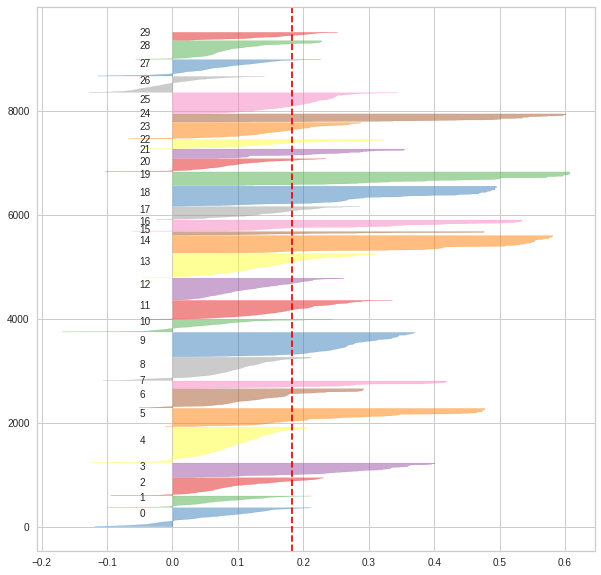

In [ ]:
# Run Kmeans model and generate Silhouette PLot to supervise the progress and select the optimal k value
NUM_CLUSTERS = 30
model = myKmeans(features, NUM_CLUSTERS, max_iter=300, n_init=10)
silhouettePlot(model)

<u>Results:</u> 

In [ ]:
# Generate dataframe with questions and labels
data = corpus[['question']].assign(labels=model.labels_)

# Print questions for each clusters
getQuestionByClusters(data, 20)


[Cluster 0] --- 20 shuffle questions
------
0) green beans
1) what should we eat for lunch?
2) what color coffee mug do i have, thank you?
3) read everything on that please.
4) hi is the can of soft drink in my right hand pepsi or coke or root beer?
5) how long do i cook this in the microwave?
6) is this cookie dough?
7) what text is on my computer screen please?
8) please identify this pill.
9) hey, is this shampoo?
10) the expiration date?
11) how much milk and water do i add to my hamburger helper?
12) is it a computer?
13) is this dayquil or nightquil?
14) hi, what does the logo say?
15) hi what is on the screen, i am not getting any sound from my tv.
16) can i use this for a headache?
17) what words are on this shirt?
18) what show is on tv?
19) good morning, is this a christmas earring? 


[Cluster 1] --- 20 shuffle questions
------
0) can you tell me the brand name of this washer?
1) please can you tell me the buttons in the picture?
2) can you tell me the calorie information a